In [ ]:
Spatial Data Science

Homework 11

Mariam Hovhannisyan

In [3]:
import gpxpy
import mplleaflet
import pykalman
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

Download and install Strava on your smartphone and create an account.

Take a bicycle ride, a car trip, or a simple run with Strava recording your activity.

Download your activity data as a .gpx file.

Analyse your own GPS trajectory using the skills you acquired in this class!

In [5]:
with open('Bycicle_ride.gpx') as fh:
    gpx_file = gpxpy.parse(fh)

In [7]:
print("File has {} track(s).".format(len(gpx_file.tracks)))
print("Track has {} segment(s).".format(len(gpx_file.tracks[0].segments)))

File has 1 track(s).
Track has 1 segment(s).


In [58]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.head()

,idx,lat,lon,ele,time
0,0,51.817414,55.170342,143.000000,2021-08-01 14:13:55+00:00
1,1,51.817243,55.170387,143.100434,2021-08-01 14:13:58+00:00
2,2,51.817290,55.170385,143.127690,2021-08-01 14:13:59+00:00
3,3,51.817463,55.170368,143.228165,2021-08-01 14:14:01+00:00
4,4,51.817466,55.170367,143.229941,2021-08-01 14:14:02+00:00


In [40]:
coords['time'] = coords['time'].astype(str).apply(lambda x: x[:19])

coords['time'] = pd.to_datetime(coords['time'], format='%Y-%m-%d %H:%M:%S')
coords.set_index('time', drop=True, inplace=True)
coords.head()

,idx,lat,lon,ele
time,,,,
2021-08-01 14:13:55,0,51.817414,55.170342,143.000000
2021-08-01 14:13:58,1,51.817243,55.170387,143.100434
2021-08-01 14:13:59,2,51.817290,55.170385,143.127690
2021-08-01 14:14:01,3,51.817463,55.170368,143.228165
2021-08-01 14:14:02,4,51.817466,55.170367,143.229941


In [41]:
# check for NaN values
print(coords.isna().values.any())

False


Text(0.5, 1.0, 'route')

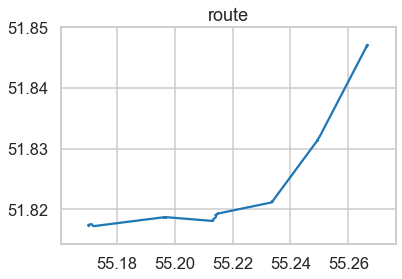

In [49]:
plt.plot(coords.lon, coords.lat)
plt.title('route')

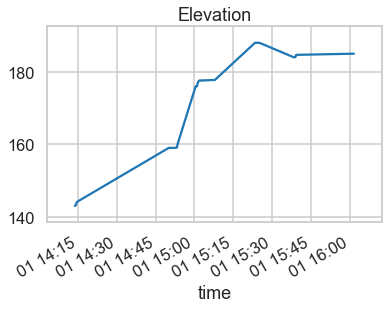

In [46]:
coords['ele'].plot(title='Elevation')
plt.show()

In [43]:
for point in segment.points:
    point.elevation = None
    
import srtm

elevation_data = srtm.get_data()
elevation_data.add_elevations(gpx_file, smooth=True)

coords['new_ele'] = [p.elevation for p in gpx_file.tracks[0].segments[0].points]
coords.head()

,idx,lat,lon,ele,new_ele
time,,,,,
2021-08-01 14:13:55,0,51.817414,55.170342,143.000000,143.000000
2021-08-01 14:13:58,1,51.817243,55.170387,143.100434,143.100434
2021-08-01 14:13:59,2,51.817290,55.170385,143.127690,143.127690
2021-08-01 14:14:01,3,51.817463,55.170368,143.228165,143.228165
2021-08-01 14:14:02,4,51.817466,55.170367,143.229941,143.229941


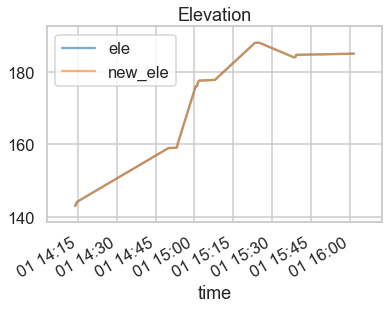

In [45]:
coords[['ele','new_ele']].plot(title='Elevation', alpha = 0.6)
plt.show()

In [64]:
#Speed data is not available, hence skipping speed analysis
start_time, end_time = segment.get_time_bounds()
duration = end_time - start_time

average_speed = segment.length_3d() / duration.seconds * 3.6
print("Average speed is {:.2f} km/h".format(average_speed))

Average speed is 4.72 km/h


In [85]:
import folium 

def plot_GPX(df, zoom):
    points = list(zip(coords.lat, coords.lon))
    latitude = sum(p[0] for p in points)/len(points)
    longitude = sum(p[1] for p in points)/len(points)
    
    myMap = folium.Map(location=[latitude,longitude],zoom_start=zoom)
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(myMap)
    folium.TileLayer('CartoDB positron').add_to(myMap)
    
    return (myMap)

In [86]:
plot_GPX(coords, 13)

In [73]:
simplified_coords = coords[["lon", "lat"]].values
simplified_coords

array([[55.170342, 51.817414],
       [55.170387, 51.817243],
       [55.170385, 51.81729 ],
       ...,
       [55.266366, 51.846959],
       [55.266376, 51.846962],
       [55.266389, 51.846965]])

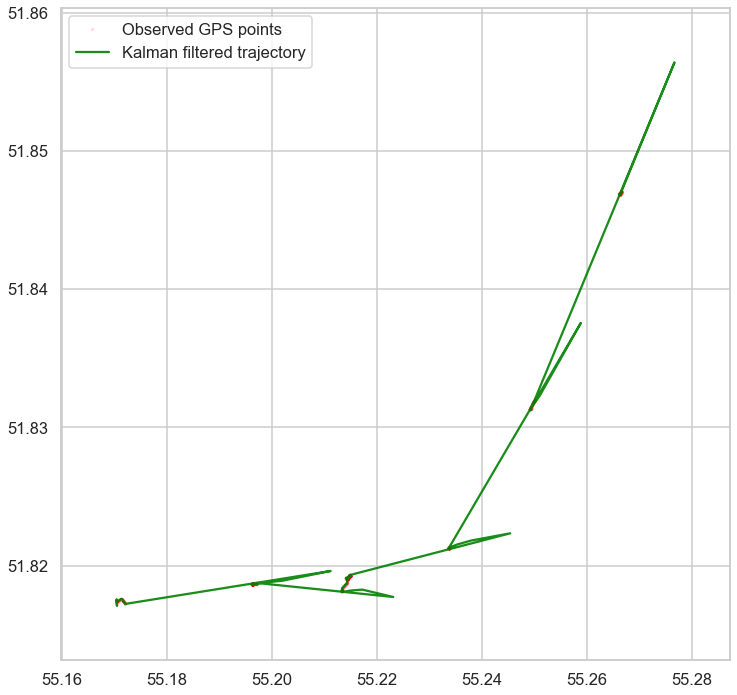

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def kalman_xy(x, P, measurement, R,
              motion = np.matrix('0. 0. 0. 0.').T,
              Q = np.matrix(np.eye(4))):
    return kalman(x, P, measurement, R, motion, Q,
                  F = np.matrix('''
                      1. 0. 1. 0.;
                      0. 1. 0. 1.;
                      0. 0. 1. 0.;
                      0. 0. 0. 1.
                      '''),
                  H = np.matrix('''
                      1. 0. 0. 0.;
                      0. 1. 0. 0.'''))

def kalman(x, P, measurement, R, motion, Q, F, H):
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P

    # PREDICT x, P based on motion
    x = F*x + motion
    P = F*P*F.T + Q

    return x, P

def demo_kalman_xy():
    x = np.matrix('0. 0. 0. 0.').T 
    P = np.matrix(np.eye(4))*100 # initial uncertainty

    N = len(simplified_coords)

    observed_x = simplified_coords[:,0]
    observed_y = simplified_coords[:,1]
    
    # plot original points along with estimates
    fig, ax = plt.subplots(figsize=(12,12))
    ax.plot(observed_x, observed_y, 'ro', alpha=0.1, markersize=2.5, label='Observed GPS points')
    result = []
    R = 0.001**2
    for meas in zip(observed_x, observed_y):
        x, P = kalman_xy(x, P, meas, R)
        result.append((x[:2]).tolist())
    kalman_x, kalman_y = zip(*result)
    plt.plot(kalman_x, kalman_y, 'g-', alpha =0.9, label='Kalman filtered trajectory')
    plt.legend()
    plt.show()

demo_kalman_xy()

Considering that the internet connection was not good on the trip route the kalman filter 'recovered' it with some faulty results

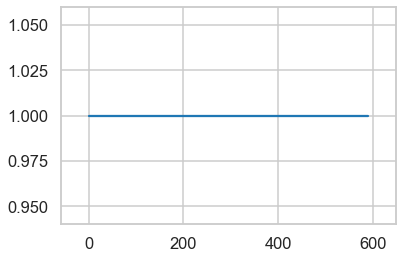

In [76]:
plt.plot(np.diff(coords.index))

In [77]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)
measurements[:10]

masked_array(
  data=[[55.170342, 51.817414, 143.0],
        [55.170387, 51.817243, 143.10043409271975],
        [55.170385, 51.81729, 143.12769004164988],
        [55.170368, 51.817463, 143.22816530035553],
        [55.170367, 51.817466, 143.22994097760065],
        [55.170368, 51.817461, 143.23286161269337],
        [55.170369, 51.817452, 143.23809132474466],
        [55.17037, 51.817451, 143.23877285972512],
        [55.170369, 51.81745, 143.2394543947062],
        [55.170369, 51.81745, 143.2394543947062]],
  mask=[[False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False],
        [False, False, False]],
  fill_value=1e+20)

In [78]:
from pykalman import KalmanFilter

F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# works initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-6, 1e-6, 1e-6])**2

In [79]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

In [80]:
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
Q = 0.5*(Q + Q.T) # assure symmetry
kf.transition_covariance = Q

In [81]:
state_means, state_vars = kf.smooth(measurements)

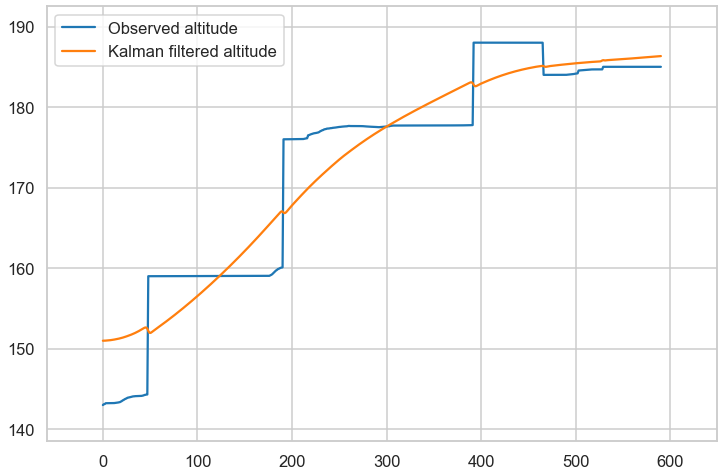

In [82]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(measurements[:,2], label="Observed altitude")
ax.plot(state_means[:,2], label="Kalman filtered altitude")
plt.legend()
plt.show()

In [83]:
segment.get_uphill_downhill()
#as this was not a round trip the uphill doesn't equal the downhill distance.
#46 uphill is quite real result

UphillDownhill(uphill=46.14278945677211, downhill=4.142789456772107)